In [217]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

In [218]:
# Paths
target = 'GINI'
SHAP_VALUES_PATH = f'output/feature_importance_NCV/{target}/country_shap_values_{target}_2000_to_2020.csv'
LOOKUP_PATH = 'output/reference/indicator_lookup.csv'
OUTPUT_DIR = 'output/shap_clustering/'

# Number of features to consider
N_FEATURES = 10

# TSNE parameters
N_COMPONENTS = 2
PERPLEXITY = 1
LEARNING_RATE = 200
N_ITER = 1000

# DBSCAN parameters
EPS = 4
MIN_SAMPLES = 2

In [219]:
print(f"{'='*50}")
print(f"SHAP CLUSTERING PARAMETERS - Target: {target}")
print(f"{'='*50}")

# Data paths
print("\n📄 DATA PATHS:")
print(f"  - SHAP values: {SHAP_VALUES_PATH}")
print(f"  - Lookup table: {LOOKUP_PATH}")
print(f"  - Output directory: {OUTPUT_DIR}")

# Analysis parameters
print("\n📊 ANALYSIS PARAMETERS:")
print(f"  - Number of features: {N_FEATURES}")

# TSNE parameters
print("\n🔄 t-SNE PARAMETERS:")
print(f"  - Components: {N_COMPONENTS}")
print(f"  - Perplexity: {PERPLEXITY}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Iterations: {N_ITER}")

# DBSCAN parameters
print("\n📌 DBSCAN PARAMETERS:")
print(f"  - Epsilon: {EPS}")
print(f"  - Minimum samples: {MIN_SAMPLES}")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"\n✅ Output directory created: {OUTPUT_DIR}")

SHAP CLUSTERING PARAMETERS - Target: GINI

📄 DATA PATHS:
  - SHAP values: output/feature_importance_NCV/GINI/country_shap_values_GINI_2000_to_2020.csv
  - Lookup table: output/reference/indicator_lookup.csv
  - Output directory: output/shap_clustering/

📊 ANALYSIS PARAMETERS:
  - Number of features: 10

🔄 t-SNE PARAMETERS:
  - Components: 2
  - Perplexity: 1
  - Learning rate: 200
  - Iterations: 1000

📌 DBSCAN PARAMETERS:
  - Epsilon: 4
  - Minimum samples: 2

✅ Output directory created: output/shap_clustering/


# Pull Data

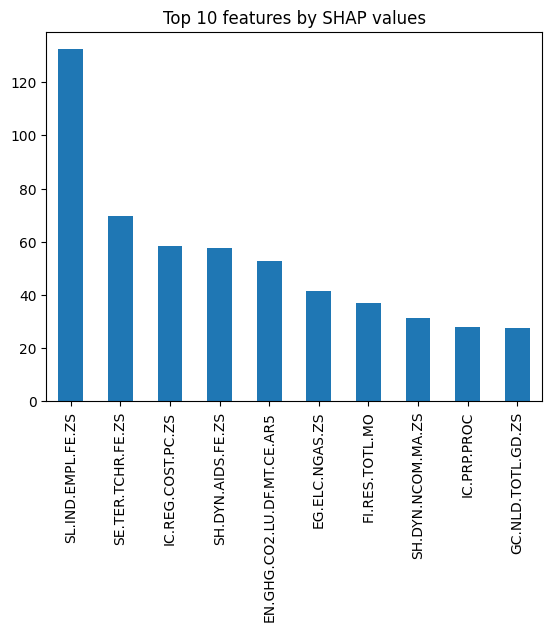

,Indicator Code,Indicator Name,Topic,Coarse_Topic
221,EG.ELC.NGAS.ZS,Electricity production from natural gas source...,Environment: Energy production & use,Environment & Climate
264,EN.GHG.CO2.LU.DF.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - ...,Climate,Environment & Climate
325,FI.RES.TOTL.MO,Total reserves in months of imports,Economic Policy & Debt: Balance of payments: R...,Economy & Finance
368,GC.NLD.TOTL.GD.ZS,Net lending (+) / net borrowing (-) (% of GDP),Public Sector: Government finance: Deficit & f...,Economy & Finance
462,IC.PRP.PROC,Procedures to register property (number),Private Sector & Trade: Business environment,Economy & Finance
465,IC.REG.COST.PC.ZS,Cost of business start-up procedures (% of GNI...,Private Sector & Trade: Business environment,Economy & Finance
946,SE.TER.TCHR.FE.ZS,"Tertiary education, academic staff (% female)",Education: Inputs,Education
994,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living wi...,Health: Risk factors,Health
1000,SH.DYN.NCOM.MA.ZS,"Mortality from CVD, cancer, diabetes or CRD be...",Health: Mortality,Health
1191,SL.IND.EMPL.FE.ZS,"Employment in industry, female (% of female em...",Social Protection & Labor: Economic activity,Economy & Finance


In [220]:
df_shap = pd.read_csv(SHAP_VALUES_PATH)
df_shap_labels = df_shap[['Country_Code', 'Country_Name']]
df_shap_data = df_shap.drop(columns=['Country_Code', 'Country_Name'])
df_shap_pivot = df_shap_data.abs().sum(axis=0).sort_values(ascending=False).head(N_FEATURES)
top_features = df_shap_pivot.index.tolist()
df_shap_pivot.plot(kind='bar')
plt.title(f'Top {N_FEATURES} features by SHAP values')
plt.show()

lookup = pd.read_csv(LOOKUP_PATH)
lookup = lookup[lookup['Indicator Code'].isin(top_features)]
display(lookup)

# t-SNE

In [221]:
tsne = TSNE(n_components=N_COMPONENTS, perplexity=PERPLEXITY, n_iter=N_ITER, learning_rate=LEARNING_RATE)
df_tsne = tsne.fit_transform(df_shap_data[top_features])
df_tsne = pd.DataFrame(df_tsne, columns=[f'TSNE_{i+1}' for i in range(N_COMPONENTS)])
df_tsne

,TSNE_1,TSNE_2
0,-17.639673,-18.415894
1,-20.150135,33.084782
2,7.496644,-16.802307
3,-23.767469,-82.760132
4,6.755587,-18.172085
...,...,...
205,-37.805080,-22.001415
206,-21.788723,47.263199
207,-42.554310,-67.273888
208,-38.180218,77.934830


# DBSCAN Clustering

In [222]:
dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
df_tsne_clustered = df_tsne.copy()
df_tsne_clustered['Cluster'] = dbscan.fit_predict(df_tsne) + 1
df_tsne_clustered

# Visualize clusters
# Separate outliers (cluster 0) from other clusters
outliers = df_tsne_clustered[df_tsne_clustered['Cluster'] == 0]
clusters = df_tsne_clustered[df_tsne_clustered['Cluster'] > 0]

# Calculate overall range to ensure proper scaling
x_min, x_max = df_tsne_clustered['TSNE_1'].min(), df_tsne_clustered['TSNE_1'].max()
y_min, y_max = df_tsne_clustered['TSNE_2'].min(), df_tsne_clustered['TSNE_2'].max()
x_center = (x_min + x_max) / 2
y_center = (y_min + y_max) / 2
overall_range = max(x_max - x_min, y_max - y_min) * 1.1  # Add 10% padding

# Create figure
fig = go.Figure()

# Add outliers as black, smaller points
fig.add_trace(go.Scatter(
    x=outliers['TSNE_1'], 
    y=outliers['TSNE_2'],
    mode='markers',
    marker=dict(color='lightgrey', size=10),
    name='Outliers (Cluster 0)'
))

# Add regular clusters with original coloring
fig.add_trace(go.Scatter(
    x=clusters['TSNE_1'], 
    y=clusters['TSNE_2'],
    mode='markers',
    marker=dict(
        color=clusters['Cluster'],
        colorscale='Viridis',
        size=10,
        colorbar=dict(title='Cluster')
    ),
    name='Clusters'
))

# Update layout with fixed aspect ratio and proper bounds
fig.update_layout(
    title='DBSCAN Clustering on TSNE',
    xaxis=dict(
        title='TSNE_1',
        range=[x_center - overall_range/2, x_center + overall_range/2],
        constrain='domain'
    ),
    yaxis=dict(
        title='TSNE_2',
        range=[y_center - overall_range/2, y_center + overall_range/2],
        scaleanchor='x',
        scaleratio=1
    ),
    legend_title='Cluster Type',
    width=800,
    height=800
)

# fig.show()

# Calculate silhouette score
if len(set(df_tsne_clustered['Cluster'])) > 1:
    silhouette_avg = silhouette_score(df_tsne, df_tsne_clustered['Cluster'])
    print(f'Silhouette Score: {silhouette_avg:.2f}')
else:
    print('Silhouette Score: Not applicable (only one cluster found)')

# Add country names to the clustering results
df_shap_clustered = pd.concat([df_shap_labels, df_tsne_clustered], axis=1)
df_shap_clustered.to_csv('output/feature_importance_NCV/bottom10/country_shap_values_bottom10_2000_to_2020_clustered.csv', index=False)

Silhouette Score: 0.83


# Interactive Plot with Hover Labels

In [223]:
# Create an enhanced visualization with country labels and SHAP values on hover
df_plot = df_shap_clustered.copy()

# Add the top features' SHAP values to the dataframe
df_plot_with_shap = pd.concat([df_plot, df_shap_data[top_features]], axis=1)

# Separate outliers from clusters for different styling
plot_outliers = df_plot_with_shap[df_plot_with_shap['Cluster'] == 0]
plot_clusters = df_plot_with_shap[df_plot_with_shap['Cluster'] > 0]

# Create hover text with country names and SHAP values for important features
def create_hover_text(row):
    text = f"<b>{row['Country_Name']}</b><br>"
    # Add top 5 SHAP values (positive or negative) for this country
    shap_values = row[top_features].abs().sort_values(ascending=False).head(5)
    for feature in shap_values.index:
        actual_value = row[feature]  # Get the actual value (not absolute)
        indicator_name = lookup[lookup['Indicator Code'] == feature]['Indicator Name'].values[0] if len(lookup[lookup['Indicator Code'] == feature]) > 0 else feature
        shortened_name = indicator_name[:30] + '...' if len(indicator_name) > 30 else indicator_name
        text += f"{shortened_name}: {actual_value:.4f}<br>"
    return text

# Apply the hover text creation function
plot_outliers['hover_text'] = plot_outliers.apply(create_hover_text, axis=1)
plot_clusters['hover_text'] = plot_clusters.apply(create_hover_text, axis=1)

# Create interactive figure with hover text
interactive_fig = go.Figure()

# Add outliers with hover text
interactive_fig.add_trace(go.Scatter(
    x=plot_outliers['TSNE_1'], 
    y=plot_outliers['TSNE_2'],
    mode='markers',
    marker=dict(color='black', size=6, line=dict(color='white', width=1)),
    name='Outliers',
    text=plot_outliers['hover_text'],
    hoverinfo='text'
))

# Add clusters with hover text
interactive_fig.add_trace(go.Scatter(
    x=plot_clusters['TSNE_1'], 
    y=plot_clusters['TSNE_2'],
    mode='markers',
    marker=dict(
        color=plot_clusters['Cluster'],
        colorscale='Viridis',
        size=12,
        line=dict(color='white', width=1),
        colorbar=dict(title='Cluster')
    ),
    name='Clusters',
    text=plot_clusters['hover_text'],
    hoverinfo='text'
))

# Use the same bounds as the previous plot but with increased margins
interactive_fig.update_layout(
    title=f't-SNE with DBSCAN Clustering - {target}',
    xaxis=dict(
        title='TSNE_1',
        range=[x_center - overall_range/2 - 5, x_center + overall_range/2 + 5],  # Add more space
        constrain='domain'
    ),
    yaxis=dict(
        title='TSNE_2',
        range=[y_center - overall_range/2 - 5, y_center + overall_range/2 + 5],  # Add more space
        scaleanchor='x',
        scaleratio=1
    ),
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=-0.15,  # Position legend below the plot
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=100, b=150, l=80, r=80),  # Increase margins all around
    width=900,
    height=900,
    hovermode='closest',
    updatemenus=[{
        'buttons': [
            {
                'method': 'update',
                'label': 'All Countries',
                'args': [{'marker.size': [6, 12], 'marker.opacity': [1, 1]}]
            },
        ] + [
            {
                'method': 'update',
                'label': country,
                'args': [
                    {  # Data arguments
                        'marker.size': [
                            [12 if df_plot_with_shap.loc[i, 'Country_Name'] == country else 6 for i in plot_outliers.index],
                            [
                                18 if df_plot_with_shap.loc[i, 'Country_Name'] == country else 
                                14 if (
                                    df_plot_with_shap.loc[df_plot_with_shap['Country_Name'] == country, 'Cluster'].values[0] > 0 and
                                    df_plot_with_shap.loc[i, 'Cluster'] == df_plot_with_shap.loc[df_plot_with_shap['Country_Name'] == country, 'Cluster'].values[0]
                                ) else 
                                6 for i in plot_clusters.index
                            ]
                        ],
                        'marker.opacity': [
                            [1.0 if df_plot_with_shap.loc[i, 'Country_Name'] == country else 0.3 for i in plot_outliers.index],
                            [
                                1.0 if df_plot_with_shap.loc[i, 'Country_Name'] == country else
                                0.8 if (
                                    df_plot_with_shap.loc[df_plot_with_shap['Country_Name'] == country, 'Cluster'].values[0] > 0 and
                                    df_plot_with_shap.loc[i, 'Cluster'] == df_plot_with_shap.loc[df_plot_with_shap['Country_Name'] == country, 'Cluster'].values[0]
                                ) else 
                                0.3 for i in plot_clusters.index
                            ]
                        ]
                    },
                    {  # Layout arguments
                        'title.text': f"t-SNE with DBSCAN Clustering - {target} - {country} {'' if df_plot_with_shap.loc[df_plot_with_shap['Country_Name'] == country, 'Cluster'].values[0] == 0 else '(Cluster: ' + str(df_plot_with_shap.loc[df_plot_with_shap['Country_Name'] == country, 'Cluster'].values[0]) + ')'}"
                    }
                ]
            } for country in sorted(df_plot_with_shap['Country_Name'].tolist())
        ],
        'direction': 'down',
        'showactive': True,
        'x': 0.1,
        'y': 1.25,
        'xanchor': 'left',
        'yanchor': 'top',
        'bgcolor': 'rgba(255,255,255,0.8)',
        'name': 'Search Country'
    }]
)

interactive_fig.write_html(f'{OUTPUT_DIR}/dbscan_tsne_clusters_{target}_interactive.html')
interactive_fig.show()

/var/folders/cj/3zyd4jkj3s1f2bnvnnc629300000gn/T/ipykernel_75838/3637905716.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cj/3zyd4jkj3s1f2bnvnnc629300000gn/T/ipykernel_75838/3637905716.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# t-SNE Parameter Tuning

In [224]:
# def run_tsne_with_parameters(data, perplexities=[5, 10, 30, 50, 100], learning_rates=[10, 100, 200, 500, 1000], n_iter=1000):
#     """Run t-SNE with different parameter combinations and visualize results"""
#     results = []
    
#     fig = make_subplots(rows=len(perplexities), cols=len(learning_rates), 
#                       subplot_titles=[f'Perp={p}, LR={lr}' for p in perplexities for lr in learning_rates],
#                       shared_xaxes=True, shared_yaxes=True)
    
#     row_idx = 1
#     for perp in perplexities:
#         col_idx = 1
#         for lr in learning_rates:
#             print(f"Running t-SNE with perplexity={perp}, learning_rate={lr}")
#             # Run t-SNE with current parameters
#             tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, n_iter=n_iter, random_state=42)
#             embeddings = tsne.fit_transform(data)
            
#             # Store results
#             results.append({
#                 'perplexity': perp,
#                 'learning_rate': lr,
#                 'embeddings': embeddings,
#                 'kl_divergence': tsne.kl_divergence_
#             })
            
#             # Add to subplot
#             fig.add_trace(
#                 go.Scatter(
#                     x=embeddings[:, 0],
#                     y=embeddings[:, 1],
#                     mode='markers',
#                     marker=dict(size=5),
#                     text=df_data_scaled_grouped_labels['Country Name'],
#                     name=f'p={perp}, lr={lr}'
#                 ),
#                 row=row_idx, col=col_idx
#             )
            
#             col_idx += 1
#         row_idx += 1
    
#     # Update layout
#     fig.update_layout(
#         height=300 * len(perplexities),
#         width=250 * len(learning_rates),
#         title_text="t-SNE Parameter Tuning",
#         showlegend=False
#     )
    
#     # Create a summary table of KL divergences
#     kl_df = pd.DataFrame([(r['perplexity'], r['learning_rate'], r['kl_divergence']) 
#                         for r in results], columns=['perplexity', 'learning_rate', 'kl_divergence'])
#     kl_pivot = kl_df.pivot(index='perplexity', columns='learning_rate', values='kl_divergence')
    
#     # Find the best parameters (lowest KL divergence)
#     best_params = kl_df.loc[kl_df['kl_divergence'].idxmin()]
    
#     return fig, kl_pivot, best_params, results

# # Run t-SNE parameter tuning with a lower perplexity range to avoid over-scattering
# tsne_fig, tsne_kl_table, best_tsne_params, tsne_results = run_tsne_with_parameters(
#     df_data_scaled_grouped,
#     perplexities=[i for i in range(1,50)],  # Lower perplexity range
#     learning_rates=[200, 500, 1000],     # Focused learning rates
#     n_iter=5000                   # Increased iterations for better convergence
# )

# tsne_fig.show()

# # Display KL divergence table
# print("\nKL Divergence by Parameter Combination:")
# display(tsne_kl_table)

# # Don't automatically use the lowest KL divergence - let's visually inspect results
# print(f"\nBest t-SNE parameters based on KL divergence: perplexity={best_tsne_params['perplexity']}, "
#       f"learning_rate={best_tsne_params['learning_rate']}, "
#       f"KL divergence={best_tsne_params['kl_divergence']:.4f}")

# # Let's also evaluate the visual quality of the embeddings
# print("\nNOTE: The lowest KL divergence doesn't always produce the best visualization.")
# print("Choose parameters that create distinct, well-separated clusters but not overly scattered points.")